#Libraries and Dates

In [2]:
#import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import tensorflow as tf

In [3]:
#Dates
training_start = "2020-09-01"
training_end = "2020-10-19"
treatment_start = "2020-10-20"
treatment_end = "2020-10-23"
end_stock = "2020-10-24"

#Loading financial data

In [4]:
#Bitcoin
y = ["BTC-USD"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1d")
y = y['Adj Close'].rename("y")
y[:1]

[*********************100%***********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

In [5]:
#Load more stock data
stocks = ["NVDA", "SQ", "CRSP", "CVNA", "JD", "ZAL.DE", "KTOS", "GOOG"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")


[*********************100%***********************]  8 of 8 completed


#Data Preparation

In [6]:
#Getting the adjusted close
X = X.iloc[:, :len(stocks)]
X.head(1)

Price                      Adj Close                                   \
Ticker                          CRSP        CVNA       GOOG        JD   
Date                                                                    
2020-09-01 00:00:00+00:00  93.419998  227.190002  82.941116  77.05854   

Price                                                               
Ticker                          KTOS       NVDA          SQ ZAL.DE  
Date                                                                
2020-09-01 00:00:00+00:00  19.700001  13.784068  166.660004   77.0

In [7]:
#Removing level
X.columns = X.columns.droplevel()
X.head(1)

Ticker,CRSP,CVNA,GOOG,JD,KTOS,NVDA,SQ,ZAL.DE
Date,,,,,,,,
2020-09-01 00:00:00+00:00,93.419998,227.190002,82.941116,77.05854,19.700001,13.784068,166.660004,77.0


In [8]:
#Time zones
X.index = X.index.tz_localize(None)
X.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [9]:
#Combine everything
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,CRSP,CVNA,GOOG,JD,KTOS,NVDA,SQ,ZAL.DE
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,227.190002,82.941116,77.058540,19.700001,13.784068,166.660004,77.000000
2020-09-02,11414.034180,93.930000,222.979996,86.315781,77.731125,19.910000,14.308164,162.880005,77.000000
2020-09-03,10245.296875,85.690002,198.509995,81.998695,73.835701,19.520000,12.980721,152.860001,75.080002
2020-09-04,10511.813477,82.019997,187.000000,79.461578,74.732491,19.260000,12.588771,146.389999,71.739998
2020-09-08,10131.516602,81.459999,181.000000,76.532410,71.201385,19.230000,11.881166,139.110001,73.440002


#Data Analysis section

In [10]:
#Prepare a dataframe with only training data
df_training = df[df.index <= training_end]
df_training.head()

,y,CRSP,CVNA,GOOG,JD,KTOS,NVDA,SQ,ZAL.DE
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,227.190002,82.941116,77.058540,19.700001,13.784068,166.660004,77.000000
2020-09-02,11414.034180,93.930000,222.979996,86.315781,77.731125,19.910000,14.308164,162.880005,77.000000
2020-09-03,10245.296875,85.690002,198.509995,81.998695,73.835701,19.520000,12.980721,152.860001,75.080002
2020-09-04,10511.813477,82.019997,187.000000,79.461578,74.732491,19.260000,12.588771,146.389999,71.739998
2020-09-08,10131.516602,81.459999,181.000000,76.532410,71.201385,19.230000,11.881166,139.110001,73.440002


In [11]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]

#how to read - ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is not stationary


In [12]:
#Differencing: subtract or divide
# df_training.pct_change().dropna()
differencing = df_training.pct_change().dropna()
differencing.head(2)

,y,CRSP,CVNA,GOOG,JD,KTOS,NVDA,SQ,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.018531,0.040687,0.008728,0.010660,0.038022,-0.022681,0.000000
2020-09-03,-0.102395,-0.087725,-0.109741,-0.050015,-0.050114,-0.019588,-0.092775,-0.061518,-0.024935


In [13]:
#Stationarity
test = adfuller(x = differencing.y)[1]

#how to read - ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is stationary


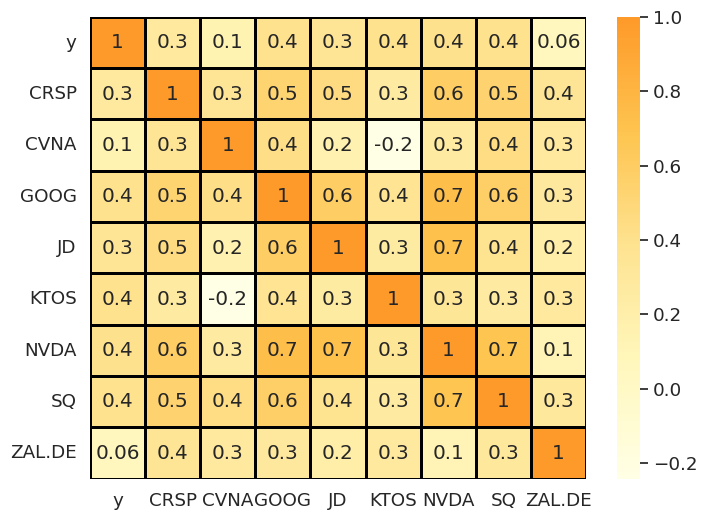

In [14]:
#Correlation Matrix
plt.figure(figsize = (8,6))
sns.set_theme(font_scale = 1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'YlOrBr',
            center =  True,
            linewidth = 1,
            linecolor = 'black')
plt.show()

#Causal Impact

In [15]:
df_final = df.drop(columns = ["ZAL.DE"])
df_final.head(1)

,y,CRSP,CVNA,GOOG,JD,KTOS,NVDA,SQ
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,227.190002,82.941116,77.05854,19.700001,13.784068,166.660004


In [16]:
#Pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06152D+00    |proj g|=  4.60850D-01

At iterate    5    f=  9.09721D-01    |proj g|=  1.67909D-01

At iterate   10    f=  8.68026D-01    |proj g|=  6.06079D-02

At iterate   15    f=  8.56003D-01    |proj g|=  9.67782D-03

At iterate   20    f=  8.55529D-01    |proj g|=  9.03159D-04

At iterate   25    f=  8.55528D-01    |proj g|=  6.01826D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     32      1     0     0   

 This problem is unconstrained.
/home/jcketterer/anaconda3/envs/econmetrics_ci/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


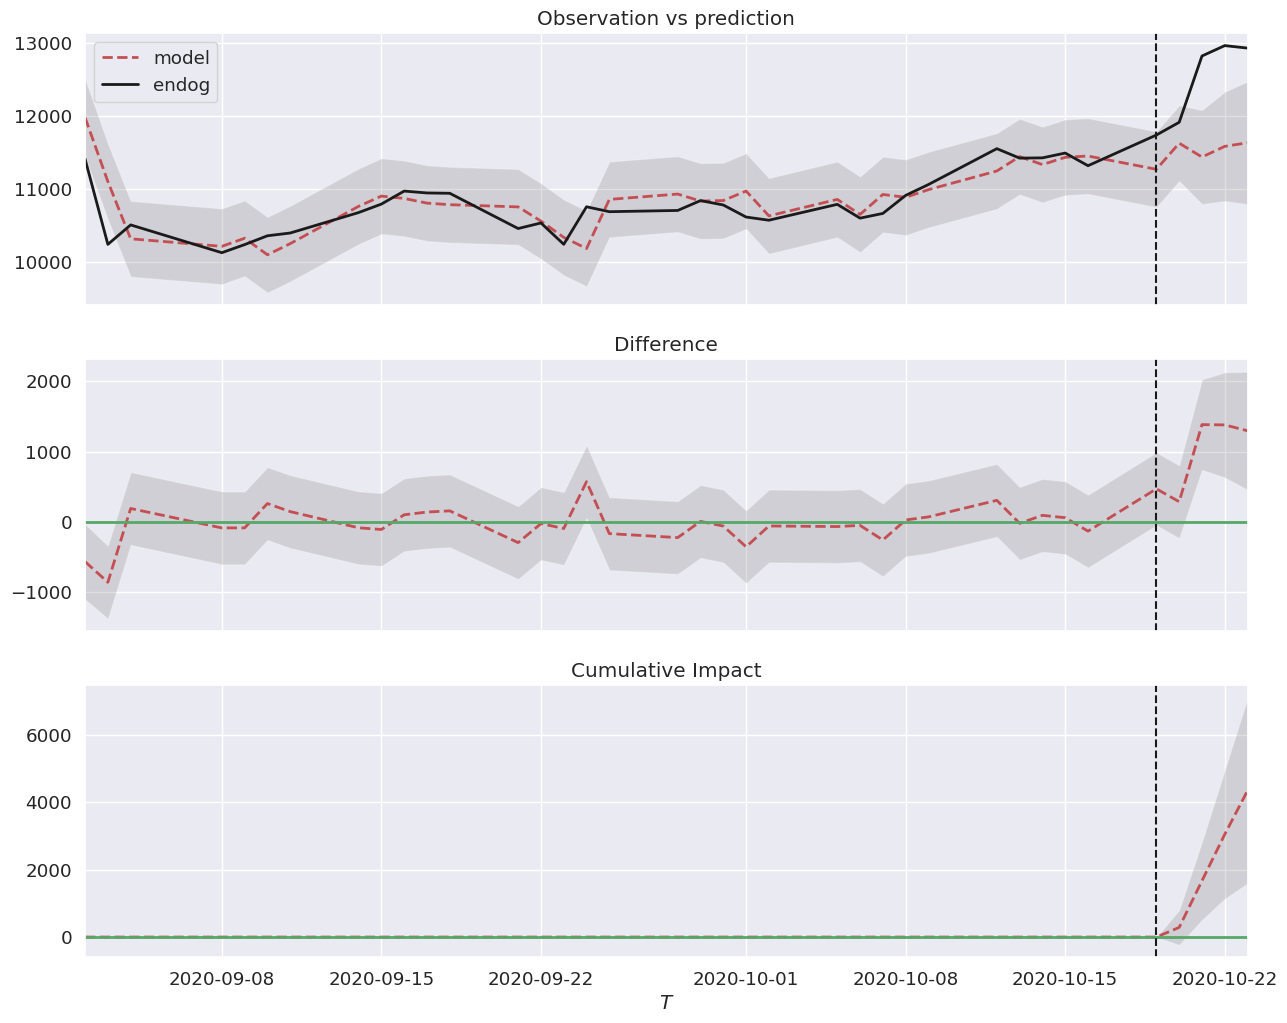

In [23]:
#Google Causal Impact

impact = CausalImpact(data = df_final,
                    pre_period = pre_period,
                    post_period = post_period)
impact.run()
impact.plot()




In [24]:
#Summary
print(impact.summary())
#1634

                               Average      Cumulative
Actual                           12659           50637
Predicted                        11573           46293
95% CI                  [10885, 12261]  [43542, 49044]
                                                      
Absolute Effect                   1085            4343
95% CI                     [1773, 398]    [7094, 1592]
                                                      
Relative Effect                   9.4%            9.4%
95% CI                   [15.3%, 3.4%]   [15.3%, 3.4%]
                                                      
P-value                           0.0%                
Prob. of Causal Effect          100.0%                
None


In [25]:
#Summary report
print(impact.summary('report'))

During the post-intervention period, the response             variable had an average value of             approx.
12659.  By contrast, in  the absence of an intervention, we would have expected an average response of 11573. The 95%
interval of this counterfactual prediction is [10885, 12261]. Subtracting this prediction from the observed response
yields an estimate of the causal effect the intervention had on the response variable. This effect is 1085 with a 95%
interval of [1773, 398]. For a discussion of the significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully
interpreted), the response variable had an overall value of 50637.  By contrast, had  the intervention not taken place,
we would have expected a sum of 46293. The 95% interval of this prediction is [43542, 49044]


 The above results are given in terms of absolute numbers. In relative terms, the response variable showed  a